# Install the neccesary packages

In [1]:
"""
Machine Learning Dataset 3 Head & Neck cancer

Aniek Sips (4560736), Jorijn van den Boom (4664027), Roos Kolthof (4545001), Kars Tjepkema (4553039)
"""

!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git
# Install the neccesary packages
!pip install numpy pandas SimpleITK scikit-image natsort scikit-learn seaborn PREDICT matplotlib

# NOTE: if you get an error when installing PREDICT concerning pywavelets,
# you can just negate it

# Install the toolbox made for this course
# !pip install -q --upgrade git+https://github.com/MStarmans91/aiptoolbox.git

# Importing all neccesary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import random
import matplotlib

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, validation_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from hn.load_data import load_data

     |████████████████████████████████| 47.4MB 131kB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 1.9MB 38.3MB/s 
     |████████████████████████████████| 194kB 47.4MB/s 
     |████████████████████████████████| 4.3MB 36.7MB/s 
     |████████████████████████████████| 102kB 9.5MB/s 
     |████████████████████████████████| 552kB 46.7MB/s 
  Created wheel for phasepack: filename=phasepack-1.5-cp37-none-any.whl size=26983 sha256=311649359bf426f21547e52a3fbc0736d9406518141200bc7f1376e1a0389401
  Stored in directory: /root/.cache/pip/wheels/70/b3/0a/eba59071a075d1192016960030f2b52751f23adfb260a3db93
Successfully built phasepack
ERROR: predict 3.1.13 has requirement PyWavelets<=1.0.0,>=0.4.0, but you'll have pywavelets 1.1.1 which is incompatible.
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


# Importing data

In [2]:
data = load_data()
data_label = data['label']
data_no_label = data.drop(['label'], axis = 1)
patient_ids = data.index

results = pd.DataFrame(columns=["label", "data_no_label"])
for patient in patient_ids:
  # To correct for potential missing data, find out if the patients data contains NaN
  if data_no_label.loc[patient].isnull().values.any() == True:
    print(f'key{patient} contains nan or is empty')
    # Drop patient that contains NaN
  else:
    patient_row = data_no_label.loc[patient]
    patient_row = patient_row.values.flatten()
    results.loc[patient] = [data_label[patient], patient_row]

data_no_label = results['data_no_label'].to_numpy().tolist()
data_label = results['label'].to_numpy()



# Display data

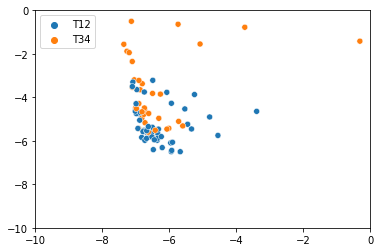

In [3]:
# SCALING
disp_sc = RobustScaler().fit(data_no_label)
X_disp_sc = disp_sc.transform(data_no_label)

# PCA
disp_pca = PCA(n_components=2).fit(X_disp_sc)
X_disp_pca = disp_pca.transform(X_disp_sc)

seaborn.scatterplot(x=X_disp_pca[:, 0], y=X_disp_pca[:, 1], hue=data_label)
plt.xlim(-10,0)   # Remove to see outliers
plt.ylim(-10,0)   # Remove to see outliers
plt.rcParams['figure.figsize'] = 10,10

# PCA - Scree Plot


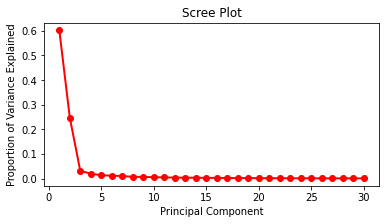

In [4]:
from sklearn.decomposition import PCA

patients_train, patients_test, labels_train, labels_test = train_test_split(data_no_label, data_label, random_state=0, test_size=0.2)

scaler = RobustScaler().fit(patients_train)
patients_train_scaled = scaler.transform(patients_train)
patients_test_scaled = scaler.transform(patients_test)

pca = PCA(n_components=30).fit(patients_train_scaled)
patients_train_pca = pca.transform(patients_train_scaled)
patients_test_pca = pca.transform(patients_test_scaled)

# Scree Plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
fig = plt.gcf()
fig.set_size_inches(6, 3)

# K fold with linear SVC

In [5]:
data_label = data['label']
data_no_label = data.drop(['label'], axis = 1)
X = data_no_label
y = np.array(data_label)

outcome_linearSVC = []
clf = LinearSVC(random_state=0, max_iter=1000000, penalty = 'l2', dual=False) 
#print(f'Default classifier: {clf}')
parameters = {'C': [0.1, 1, 10, 100]}

kf = KFold(n_splits=113, shuffle=True)
for train_index, test_index in kf.split(X):
    # GET TRAINING AND TEST SET
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index]
    X_train = X_train.values.tolist()

    # PREPROCESSING (SCALING) ON TRAINING SET
    scaler = RobustScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)

    # PCA ON TRAINING SET
    pca = PCA(n_components=10).fit(X_train_scaled)
    X_train_PCA = pca.transform(X_train_scaled)
    # APPLY CLASSIFIER  
    clf.fit(X_train_PCA, y_train)

    # HYPER PARAMETER OPTIMIZATION
    grid = GridSearchCV(clf, parameters, cv=5)
    grid_result = grid.fit(X_train_PCA, y_train)
    clf_hyp = grid.best_estimator_
    y_train_hyp = clf_hyp.predict(X_train_PCA)
    acc = accuracy_score(y_train, y_train_hyp)
    
    # EVALUATION ON TEST SET
    # Apply preprocessing on test set
    X_test_scaled = scaler.transform(X_test)
    # Apply pca on test set
    X_test_PCA = pca.transform(X_test_scaled)

    # Apply classifier on test
    y_test_hyp = clf.predict(X_test_PCA)
    acc_test = accuracy_score(y_test, y_test_hyp) 
    outcome_linearSVC.append([grid_result.best_params_, acc, acc_test, y_test])

df_linearSVC = pd.DataFrame(data=outcome_linearSVC)
df_linearSVC.columns = ['Best param', 'Accuracy train', 'Accuracy test', 'y_test']

display(df_linearSVC)
print('Mean accuracy linear SVC:', np.mean(df_linearSVC['Accuracy test']))

,Best param,Accuracy train,Accuracy test,y_test
0,{'C': 0.1},0.741071,1.0,[T12]
1,{'C': 1},0.750000,1.0,[T12]
2,{'C': 1},0.758929,0.0,[T34]
3,{'C': 0.1},0.750000,1.0,[T12]
4,{'C': 1},0.767857,0.0,[T12]
...,...,...,...,...
108,{'C': 0.1},0.741071,1.0,[T34]
109,{'C': 0.1},0.767857,1.0,[T12]
110,{'C': 1},0.758929,1.0,[T34]
111,{'C': 10},0.767857,0.0,[T34]


Mean accuracy linear SVC: 0.6902654867256637


In [6]:
all_param = df_linearSVC['Best param'].value_counts()
list_all_param = all_param.index.tolist()

hyp_linearSVC = []
for C in list_all_param:
  df_only_C = df_linearSVC[df_linearSVC['Best param'] == C]
  f= df_linearSVC[df_linearSVC['Best param'] == C].count()[0]
  hyp_linearSVC.append([C, np.mean(df_only_C['Accuracy test']), f])
df_hyp_linearSVC= pd.DataFrame(data=hyp_linearSVC)
df_hyp_linearSVC.columns = ['Param linear SVC', 'Accuracy test', 'Freq']
display(df_hyp_linearSVC)

,Param linear SVC,Accuracy test,Freq
0,{'C': 0.1},0.694915,59
1,{'C': 1},0.723404,47
2,{'C': 10},0.428571,7


# K fold with SVC kernel(s)

In [7]:
data_label = data['label']
data_no_label = data.drop(['label'], axis = 1)
X = data_no_label
y = np.array(data_label)

outcome_SVC = []
clf = SVC() 
print(f'Default classifier: {clf}')

parameters = {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']}

kf = KFold(n_splits=113, random_state=0, shuffle=True)
for train_index, test_index in kf.split(X):
    # GET TRAINING AND TEST SET
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index]
    X_train = X_train.values.tolist()

    # PREPROCESSING (SCALING) ON TRAINING SET
    scaler = RobustScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)

    # PCA ON TRAINING SET
    pca = PCA(n_components=10).fit(X_train_scaled)
    X_train_PCA = pca.transform(X_train)
    # APPLY CLASSIFIER  
    clf.fit(X_train_PCA, y_train)

    # HYPER PARAMETER OPTIMIZATION
    grid = GridSearchCV(clf, parameters, cv=5)
    grid_result = grid.fit(X_train_PCA, y_train)
    clf_hyp = grid.best_estimator_
    y_train_hyp = clf_hyp.predict(X_train_PCA)
    acc = accuracy_score(y_train, y_train_hyp)

    # EVALUATION ON TEST SET
    # Apply preprocessing on test set
    X_test_scaled = scaler.transform(X_test)
    # Apply pca on test set
    X_test_PCA = pca.transform(X_test_scaled)

    # Apply classifier on test
    y_test_hyp = clf_hyp.predict(X_test_PCA)
    acc_test = accuracy_score(y_test, y_test_hyp) 
    outcome_SVC.append([grid_result.best_params_, acc, acc_test]) 
 
df_SVC = pd.DataFrame(data=outcome_SVC)
df_SVC.columns = ['Best param', 'Accuracy train', 'Accuracy test']

display(df_SVC)
print(np.mean(df_SVC['Accuracy test']))

Default classifier: SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


,Best param,Accuracy train,Accuracy test
0,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.508929,1.0
1,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.517857,0.0
2,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.517857,0.0
3,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.508929,1.0
4,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.508929,1.0
...,...,...,...
108,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.508929,1.0
109,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.517857,0.0
110,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.508929,1.0
111,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.517857,0.0


0.5132743362831859


# K fold with RF


In [ ]:
data_label = data['label']
data_no_label = data.drop(['label'], axis = 1)
X = data_no_label
y = np.array(data_label)

outcome_RF = []

clf = RandomForestClassifier(random_state=0, bootstrap=True)
print(f'Default classifier: {clf}')

max_features = list(range(10,X.shape[1]))
random_grid = {'n_estimators': [1, 10, 50, 100, 200, 500], 'max_features': [1, round(0.25*113), round(0.5*113), round(0.75*113), 113]}

kf = KFold(n_splits=113, random_state=42, shuffle=True)
for train_index, test_index in kf.split(X):
    # GET TRAINING AND TEST SET
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index]
    
    X_train= X_train.values.tolist()
    X_test = X_test.values.tolist()

    # PREPROCESSING (SCALING) ON TRAINING SET
    scaler = RobustScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    
    # APPLY CLASSIFIER
    clf.fit(X_train_scaled, y_train)

    # HYPER PARAMETER OPTIMIZATION
    grid = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter=30, cv = 5)
    grid_result = grid.fit(X_train_scaled, y_train)
    clf_hyp = grid.best_estimator_
    y_train_hyp = clf_hyp.predict(X_train_scaled)
    acc_train = accuracy_score(y_train, y_train_hyp)
    
    # EVALUATION ON TEST SET
    # Apply preprocessing on test set
    X_test_scaled = scaler.transform(X_test)
    
    # Apply classifier on test set
    y_test_hyp = clf_hyp.predict(X_test_scaled)
    acc_test = accuracy_score(y_test, y_test_hyp)
    outcome_RF.append([grid_result.best_params_, acc_train, acc_test])

df_RF = pd.DataFrame(data=outcome_RF)
df_RF.columns = ['Best param', 'Accuracy train', 'Accuracy test']

display(df_RF)
print('Mean accuracy train RF:', np.mean(df_RF['Accuracy train']))
print('Mean accuracy test RF:', np.mean(df_RF['Accuracy test']))

Default classifier: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


In [ ]:
all_param = df_RF['Best param'].value_counts()
list_all_param = all_param.index.tolist()

hyp_RF = []
for C in list_all_param:
  df_only_C = df_RF[df_RF['Best param'] == C]
  f= df_RF[df_RF['Best param'] == C].count()[0]
  hyp_RF.append([C, np.mean(df_only_C['Accuracy test']), f])
df_hyp_RF= pd.DataFrame(data=hyp_RF)
df_hyp_RF.columns = ['Param RF', 'Accuracy test', 'Freq']
display(df_hyp_RF)

Function to plot the training curve of the two hyperparameters 'number of trees' and 'maximum features' for the Random Forest Classifier. 

In [ ]:
# PLOTTING TRAINING CURVES FUNCTION
def plot_results(model, name = 'Num Trees'):

  # Extract information from the CV model 
  train_scores = model['Mean_Train_Score'].mean()
  test_scores = model['Mean_Test_Score'].mean()
  train_time = model['Mean_Fit_Time'].mean()
  param_values = list(model['Param_Name'].iloc[1])
  print(train_scores)
  print(param_values)

  train_scores_std = model['Mean_Train_Score'].to_numpy().std()
  test_scores_std = model['Mean_Test_Score'].to_numpy().std()
  train_time_std = model['Mean_Fit_Time'].to_numpy().std()

  # Plot the scores over the parameter
  plt.subplots(1, 2, figsize=(10, 6))
  plt.subplot(121)
  plt.plot(param_values, train_scores, 'bo-', label = 'train')
  plt.plot(param_values, test_scores, 'go-', label = 'test')
  plt.fill_between(param_values, train_scores-train_scores_std, train_scores+train_scores_std, 'b', alpha=.2)
  plt.fill_between(param_values, test_scores-test_scores_std, test_scores+test_scores_std, 'g', alpha=.2)
  plt.ylim(ymin = 0.0, ymax = 1.2)
  plt.legend()
  plt.xlabel(name)
  plt.ylabel('Accuracy')
  plt.title('Accuracy vs %s' % name)
    
  plt.subplot(122)
  plt.plot(param_values, train_time, 'ro-')
  plt.fill_between(param_values, train_time-train_time_std, train_time+train_time_std, 'r',alpha=.2)
  plt.ylim(ymin = 0.0, ymax = 1.0)
  plt.xlabel(name)
  plt.ylabel('Train Time (sec)')
  plt.title('Training Time vs %s' % name)
    
  plt.tight_layout(pad = 4)


In [ ]:
# TRAINING CURVES - number of trees 
data_label = data['label']
data_no_label = data.drop(['label'], axis = 1)
X = data_no_label
y = np.array(data_label)

outcome_RF_tree = []

clf = RandomForestClassifier(random_state=0, bootstrap=True)
print(f'Default classifier: {clf}')

kf = KFold(n_splits=113, random_state=42, shuffle=True)
for train_index, test_index in kf.split(X):
    # GET TRAINING AND TEST SET
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index]
    
    X_train= X_train.values.tolist()
    X_test = X_test.values.tolist()

    # PREPROCESSING (SCALING) ON TRAINING SET
    scaler = RobustScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)

    # APPLY CLASSIFIER
    clf.fit(X_train_scaled, y_train)

    # Grid with only the number of trees changed
    tree_grid = {'n_estimators': [1, 10, 50, 100, 500]}
    # Create the grid search model and fit to the training data
    tree_grid_search = GridSearchCV(clf, param_grid=tree_grid, cv=5, scoring='accuracy', return_train_score=True)
    tree_grid_search.fit(X_train_scaled, y_train)
    tree_grid_result = tree_grid_search.cv_results_

    # Collecting relevant data
    param = 'n_estimators'
    param_name = 'param_%s' % param
    outcome_RF_tree.append([tree_grid_result['mean_train_score'], tree_grid_result['mean_test_score'], tree_grid_result['mean_fit_time'], tree_grid_result[param_name]])

# Creating final dataframe for the number of trees 
df_RF_tree = pd.DataFrame(data=outcome_RF_tree)
df_RF_tree.columns = ['Mean_Train_Score', 'Mean_Test_Score', 'Mean_Fit_Time', 'Param_Name']
display(df_RF_tree)

# Plotting trainings curve of the accuracy vs number of trees and train time vs number of trees
plot_results(df_RF_tree)

In [ ]:
# TRAINING CURVES - number of features 
data_label = data['label']
data_no_label = data.drop(['label'], axis = 1)
X = data_no_label
y = np.array(data_label)

outcome_RF_feature = []

clf = RandomForestClassifier(random_state=0, bootstrap=True)
print(f'Default classifier: {clf}')

kf = KFold(n_splits=113, random_state=42, shuffle=True)
for train_index, test_index in kf.split(X):
    # GET TRAINING AND TEST SET
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index]
    
    X_train= X_train.values.tolist()
    X_test = X_test.values.tolist()

    # PREPROCESSING (SCALING) ON TRAINING SET
    scaler = RobustScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)

    # APPLY CLASSIFIER
    clf.fit(X_train_scaled, y_train)

    # Define a grid over only the maximum number of features
    feature_grid = {'max_features': [1, round(0.25*113), round(0.5*113), round(0.75*113), 113]}
    # Create the grid search and fit on the training data 
    feature_grid_search = GridSearchCV(clf, param_grid=feature_grid, cv=5, scoring='accuracy', return_train_score=True)
    feature_grid_search.fit(X_train_scaled, y_train)
    feature_grid_result = feature_grid_search.cv_results_

    # Collecting relevant data
    param = 'max_features'
    param_name = 'param_%s' % param
    outcome_RF_feature.append([feature_grid_result['mean_train_score'], feature_grid_result['mean_test_score'], feature_grid_result['mean_fit_time'], feature_grid_result[param_name]])

# Creating final dataframe for the maximum number of features 
outcome_RF_feature = pd.DataFrame(data=outcome_RF_feature)
outcome_RF_feature.columns = ['Mean_Train_Score', 'Mean_Test_Score', 'Mean_Fit_Time', 'Param_Name']

# Plotting trainings curve of the accuracy vs max features and train time vs max features
plot_results(outcome_RF_feature, name = 'Max Features')


# K fold with k-NN


In [ ]:
data_label = data['label']
data_no_label = data.drop(['label'], axis = 1)
X = data_no_label
y = np.array(data_label)

outcome_kNN = []
clf = KNeighborsClassifier()
print(f'Default classifier: {clf}')
parameters = {'n_neighbors': [1, 5, 10, 50], 'weights': ['uniform', 'distance']}
param_range = [1, 5, 10, 50]

kf = KFold(n_splits=113, random_state=42, shuffle=True)
for train_index, test_index in kf.split(X):
    # GET TRAINING AND TEST SET
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index]
    
    X_train= X_train.values.tolist()
    X_test = X_test.values.tolist()

    # PREPROCESSING (SCALING) ON TRAINING SET
    scaler = RobustScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    # PCA ON TRAINING SET
    pca = PCA(n_components=10)
    pca.fit(X_train_scaled)
    X_train_PCA = pca.transform(X_train)
    
    # APPLY CLASSIFIER
    clf.fit(X_train_PCA, y_train)

    # HYPER PARAMETER OPTIMIZATION
    grid = GridSearchCV(clf, parameters, cv=5)
    grid_result = grid.fit(X_train_PCA, y_train)
    clf_hyp = grid.best_estimator_
    y_train_hyp = clf.predict(X_train_PCA)
    acc_train = accuracy_score(y_train, y_train_hyp)

    # EVALUATION ON TEST SET
    # Apply preprocessing on test set
    X_test_scaled = scaler.transform(X_test)
    # Apply pca on test set
    X_test_PCA = pca.transform(X_test_scaled)

    # Apply classifier on test set
    y_test_hyp = clf.predict(X_test_PCA)
    acc_test = accuracy_score(y_test, y_test_hyp)
    outcome_kNN.append([grid_result.best_params_, acc_train, acc_test])

df_kNN = pd.DataFrame(data=outcome_kNN)
df_kNN.columns = ['Best param', 'Accuracy train', 'Accuracy test']

display(df_kNN)

print('Mean accuracy k-NN:', np.mean(df_kNN['Accuracy test']))